In [ ]:
# ====================== LSTM MODEL NOTEBOOK ======================
# This notebook loads dataset.csv, cleans/preps the data (similarly to Milestone 1),
# then trains an LSTM model to predict Bitcoin's future price.
# By default, we create sequences of the last 30 days to predict the next day.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# ====== STEP 1: LOAD & INSPECT DATA ======
df = pd.read_csv("dataset.csv")
print("Initial shape:", df.shape)
print("First few rows:")
display(df.head())

# Convert 'date' column to datetime & set as index if it exists
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)

print("\nData info after setting index (if applicable):")
display(df.info())

Initial shape: (55704, 10)
First few rows:


,Unnamed: 0,open,high,low,close,volume,marketCap,timestamp,crypto_name,date
0,0,112.900002,118.800003,107.142998,115.910004,0.0,1.288693e+09,2013-05-05T23:59:59.999Z,Bitcoin,2013-05-05
1,1,3.493130,3.692460,3.346060,3.590890,0.0,6.229819e+07,2013-05-05T23:59:59.999Z,Litecoin,2013-05-05
2,2,115.980003,124.663002,106.639999,112.300003,0.0,1.249023e+09,2013-05-06T23:59:59.999Z,Bitcoin,2013-05-06
3,3,3.594220,3.781020,3.116020,3.371250,0.0,5.859436e+07,2013-05-06T23:59:59.999Z,Litecoin,2013-05-06
4,4,112.250000,113.444000,97.699997,111.500000,0.0,1.240594e+09,2013-05-07T23:59:59.999Z,Bitcoin,2013-05-07



Data info after setting index (if applicable):
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 55704 entries, 2013-05-05 to NaT
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   55704 non-null  int64  
 1   open         55704 non-null  float64
 2   high         55704 non-null  float64
 3   low          55704 non-null  float64
 4   close        55704 non-null  float64
 5   volume       55704 non-null  float64
 6   marketCap    55704 non-null  float64
 7   timestamp    55704 non-null  object 
 8   crypto_name  55703 non-null  object 
dtypes: float64(6), int64(1), object(2)
memory usage: 4.2+ MB


None

In [ ]:
# ====== STEP 2: BASIC CLEANING ======
# Drop unneeded columns
for col in ['Unnamed: 0','timestamp']:
    if col in df.columns:
        df.drop(columns=[col], inplace=True)

# Keep only Bitcoin (if crypto_name column is present)
if 'crypto_name' in df.columns:
    df = df[df['crypto_name'] == 'Bitcoin']
    df.drop(columns=['crypto_name'], inplace=True)

# Interpolate missing values
df.interpolate(method='linear', inplace=True)

# Drop rows that still have NaNs if any remain
df.dropna(inplace=True)
print("\nData shape after cleaning:", df.shape)



Data shape after cleaning: (2925, 6)


In [ ]:
# ====== STEP 3: OPTIONAL OUTLIER REMOVAL (IQR) ======
price_cols = ['open','high','low','close']
df.dropna(subset=price_cols, inplace=True)  # ensure these cols exist

Q1 = df[price_cols].quantile(0.25)
Q3 = df[price_cols].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

mask = ~((df[price_cols] < lower_bound) | (df[price_cols] > upper_bound)).any(axis=1)
df = df[mask]
print("Shape after outlier removal:", df.shape)

Shape after outlier removal: (2774, 6)


In [ ]:
# ====== STEP 4: FEATURE ENGINEERING ======
# We'll add some simple features: moving averages & daily returns.
# Adjust or remove if your dataset doesn't have these.

df['SMA_7'] = df['close'].rolling(window=7).mean()
df['SMA_30'] = df['close'].rolling(window=30).mean()
df['Daily_Return'] = df['close'].pct_change()
df.dropna(inplace=True)  # remove any NaNs introduced by rolling

print("Data after feature engineering:")
display(df.head())

Data after feature engineering:


,open,high,low,close,volume,marketCap,SMA_7,SMA_30,Daily_Return
date,,,,,,,,,
2013-06-03,122.500000,122.500000,116.000000,122.222000,0.0,1.373708e+09,127.559000,122.037966,-0.000572
2013-06-04,120.737000,123.839996,119.099998,121.419998,0.0,1.365338e+09,126.476143,122.221633,-0.006562
2013-06-05,121.400002,123.469002,119.899002,121.650002,0.0,1.368486e+09,124.954714,122.533299,0.001894
2013-06-06,121.900002,123.099998,117.250000,118.000000,0.0,1.327960e+09,123.412000,122.749966,-0.030004
2013-06-07,118.970001,119.000000,106.419998,111.500000,0.0,1.255259e+09,120.912000,122.681099,-0.055085


In [ ]:
# ====== STEP 5: SCALING THE DATA ======
# LSTM models often benefit from normalization or scaling of inputs.
# We'll use MinMaxScaler on relevant columns.

scaler = MinMaxScaler(feature_range=(0,1))

# Select columns for scaling (adjust as needed)
scale_cols = ['open','high','low','close','SMA_7','SMA_30','Daily_Return']
scale_cols = [c for c in scale_cols if c in df.columns]  # ensure they exist

df[scale_cols] = scaler.fit_transform(df[scale_cols])

print("First few rows after scaling:")
display(df.head())

First few rows after scaling:


,open,high,low,close,volume,marketCap,SMA_7,SMA_30,Daily_Return
date,,,,,,,,,
2013-06-03,0.002760,0.002395,0.002655,0.002750,0.0,1.373708e+09,0.002754,0.001787,0.463107
2013-06-04,0.002670,0.002462,0.002818,0.002709,0.0,1.365338e+09,0.002698,0.001797,0.455633
2013-06-05,0.002704,0.002444,0.002860,0.002721,0.0,1.368486e+09,0.002618,0.001814,0.466185
2013-06-06,0.002729,0.002425,0.002720,0.002535,0.0,1.327960e+09,0.002537,0.001825,0.426381
2013-06-07,0.002579,0.002220,0.002151,0.002202,0.0,1.255259e+09,0.002406,0.001822,0.395084


In [ ]:
# ====== STEP 6: PREPARE SEQUENCES FOR LSTM ======
# We'll predict the "next day's close" using the previous N days of features.
# Let's define a helper function to build sequences of length N.

sequence_length = 30  # how many past days to include in each sequence?

def create_sequences(data, target, seq_length):
    """
    data: NumPy array of shape (num_samples, num_features)
    target: NumPy array of the 'close' or next-day price to predict
    seq_length: how many time steps per sample
    Returns:
       X_seq, y_seq (both are arrays)
    """
    Xs, ys = [], []
    for i in range(len(data) - seq_length):
        Xs.append(data[i:i+seq_length])
        ys.append(target[i+seq_length])
    return np.array(Xs), np.array(ys)

# We'll define our feature set (X) and target (Y)
# Our target is still the actual "close" price, but shifted by 1 day in the create_sequences logic.

features = ['open','high','low','close','SMA_7','SMA_30','Daily_Return']
features = [f for f in features if f in df.columns]  # safety check

X_raw = df[features].values
y_raw = df['close'].values  # we want to predict 'close'

X_seq, y_seq = create_sequences(X_raw, y_raw, sequence_length)
print("X_seq shape:", X_seq.shape)
print("y_seq shape:", y_seq.shape)

# We'll do an 80/20 split on these *sequences* (not on df directly).
train_size = int(len(X_seq) * 0.8)
X_train_seq = X_seq[:train_size]
y_train_seq = y_seq[:train_size]
X_test_seq = X_seq[train_size:]
y_test_seq = y_seq[train_size:]

print("Train sequences:", X_train_seq.shape, "Test sequences:", X_test_seq.shape)

X_seq shape: (2715, 30, 7)
y_seq shape: (2715,)
Train sequences: (2172, 30, 7) Test sequences: (543, 30, 7)


In [ ]:
# ====== STEP 7: BUILD & TRAIN THE LSTM MODEL ======

model = Sequential()
model.add(LSTM(64, return_sequences=False, input_shape=(sequence_length, len(features))))
model.add(Dropout(0.2))
model.add(Dense(1))  # single output: next day's closing price

model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))

# Training
epochs = 10
batch_size = 32

history = model.fit(
    X_train_seq, y_train_seq,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0015 - val_loss: 0.0041
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0108 - val_loss: 0.0042
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0026 - val_loss: 0.0074
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0023 - val_loss: 5.8592e-04
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 5.2673e-04 - val_loss: 3.8214e-04
Epoch 6/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 4.1608e-04 - val_loss: 3.6257e-04
Epoch 7/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 3.5701e-04 - val_loss: 4.9263e-04
Epoch 8/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 3.7264e-04 - val_loss: 3.8819e-04
Epoch 9/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 4.2395e-04 - val_loss: 5.2958e-04
Epoch 10/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4.2571e-04 - val_loss: 4.8051e-04


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
LSTM MODEL EVALUATION:
 MSE  = 0.0008
 RMSE = 0.0284
 MAE  = 0.0201


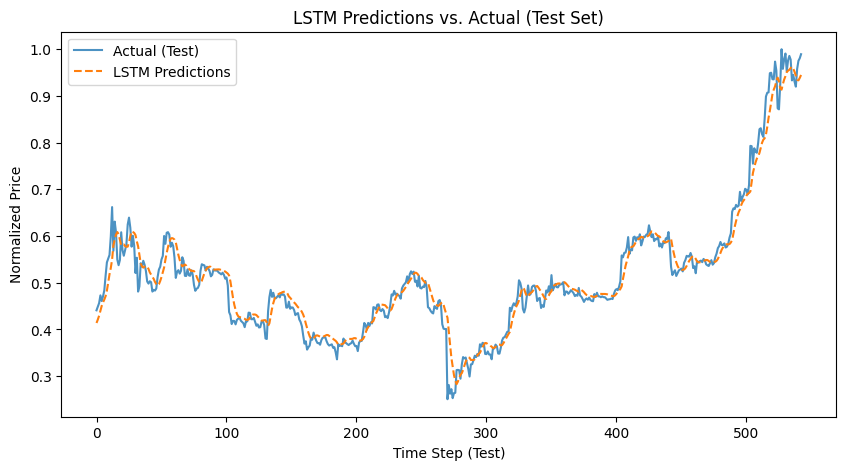

In [ ]:
# ====== STEP 8: EVALUATE ON TEST SET ======
preds_test = model.predict(X_test_seq)

mse_lstm = mean_squared_error(y_test_seq, preds_test)
rmse_lstm = np.sqrt(mse_lstm)
mae_lstm = mean_absolute_error(y_test_seq, preds_test)

print("LSTM MODEL EVALUATION:")
print(f" MSE  = {mse_lstm:.4f}")
print(f" RMSE = {rmse_lstm:.4f}")
print(f" MAE  = {mae_lstm:.4f}")

# Optional: Plot the predictions vs. actual
plt.figure(figsize=(10,5))
plt.plot(y_test_seq, label='Actual (Test)', alpha=0.8)
plt.plot(preds_test, label='LSTM Predictions', linestyle='--')
plt.title("LSTM Predictions vs. Actual (Test Set)")
plt.xlabel("Time Step (Test)")
plt.ylabel("Normalized Price")
plt.legend()
plt.show()